<a href="https://colab.research.google.com/github/zigzagw/relex_homework/blob/main/forecast_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
%matplotlib inline
# Follows from here: https://github.com/bhattbhavesh91/auto-regressive-time-series-model/blob/master/AR-model-notebook.ipynb

### Training dataset: overview

In [5]:
!ls '/content/drive/My Drive/21mai/relex/forecasting/Data'

Test_X.csv  Test_Y.csv	Train_XY.csv


In [6]:
df = pd.read_csv('/content/drive/My Drive/21mai/relex/forecasting/Data/Train_XY.csv', sep = ';')
print(df.shape)
df.set_index('dates', inplace=True)
df.sort_values('dates',inplace=True)
df.head()

(3895, 5)


,product,quantity,price,promotion
dates,,,,
2017-01-01,3,16.0,111.99,NaN
2017-01-01,2,84.0,20.00,NaN
2017-01-01,4,8.2,19.99,NaN
2017-01-02,2,78.0,20.00,NaN
2017-01-02,4,11.7,19.99,NaN


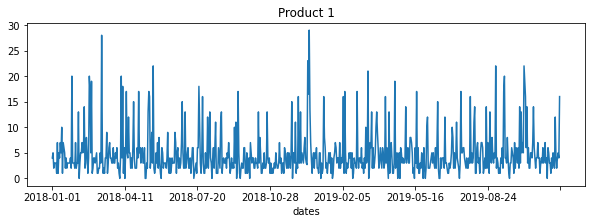

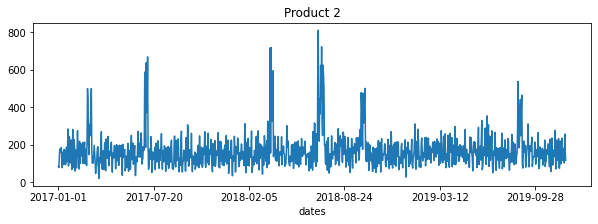

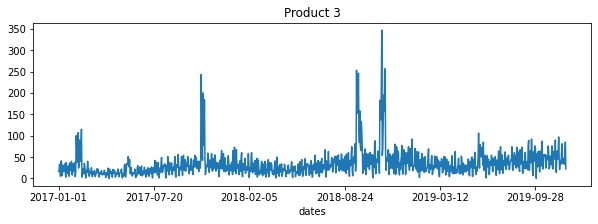

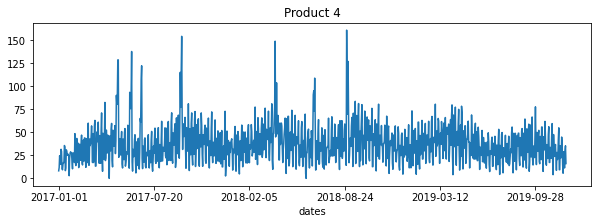

In [7]:
for i in range(1,5):
  prod = df.loc[df['product'] == i]['quantity']
  prod.plot(figsize=(10, 3))
  plt.title(f'Product {i}')
  plt.show()

### Forecast each Product with Autoregressive (AR) model

In [106]:
num_product = 4 # choise product number for Forecast (1-4)

In [107]:

df = pd.read_csv('/content/drive/My Drive/21mai/relex/forecasting/Data/Train_XY.csv', sep = ';')
print (df.shape)
print (f"dates: {df['dates'].min()} {df['dates'].max()}")

df.set_index('dates', inplace=True)
df.sort_values('dates',inplace=True)
prod_train = df.loc[df['product'] == num_product]['quantity']
train_size = len(prod_train)-1
print(prod_train)

(3895, 5)
dates: 2017-01-01 2019-12-01
dates
2017-01-01     8.2
2017-01-02    11.7
2017-01-03    24.6
2017-01-04    17.6
2017-01-05    15.2
              ... 
2019-11-27    27.4
2019-11-28    11.3
2019-11-29    29.0
2019-11-30    35.4
2019-12-01    16.1
Name: quantity, Length: 1065, dtype: float64


In [108]:
df_testY = pd.read_csv('/content/drive/My Drive/21mai/relex/forecasting/Data/Test_Y.csv', sep = ';')
print(df_testY.shape)
df_testY.set_index('dates', inplace=True)
df_testY.sort_values('dates',inplace=True)
prod_test = df_testY.loc[df_testY['product'] == num_product]['quantity']
print(prod_test)

(120, 3)
dates
2019-12-02     9.7
2019-12-03    25.0
2019-12-04     9.7
2019-12-05    23.6
2019-12-06    31.9
2019-12-07    41.6
2019-12-08     8.3
2019-12-09     4.2
2019-12-10    23.0
2019-12-11    14.4
2019-12-12    13.0
2019-12-13    28.8
2019-12-14    40.3
2019-12-15     7.2
2019-12-16     8.6
2019-12-17     7.7
2019-12-18    20.0
2019-12-19    16.9
2019-12-20    26.2
2019-12-21    37.0
2019-12-22    18.5
2019-12-23    10.8
2019-12-24    57.4
2019-12-25    63.9
2019-12-26    66.0
2019-12-27    68.2
2019-12-28    68.2
2019-12-29    36.0
2019-12-30    38.1
2019-12-31    17.5
Name: quantity, dtype: float64


In [109]:
prod = pd.concat([prod_train, prod_test], axis= 0)

print(len(prod))

1095


In [110]:
X = prod.to_numpy(dtype=np.float32)
print(X.shape)
X_train = X[:train_size]
print(X_train.shape)

(1095,)
(1064,)


In [111]:
# ADF test for stationarity cehck-up
result = adfuller(X_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -4.440024
p-value: 0.000252
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Reject Ho - Time Series is Stationary


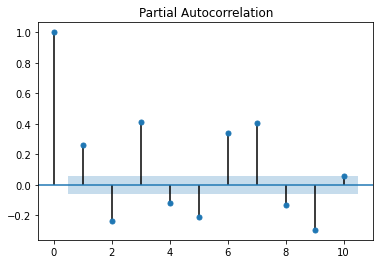

In [112]:
# Let's look how many terms we need to use in Autoregressive model
plot_pacf(X_train, lags=10);

We can use only value from one day before for AR model.

In [113]:
# Generate a one day shifted time series
frame = { 'prod': prod, 'shifted_prod': prod.shift(1) }
df_prod = pd.DataFrame(frame)
df_prod.tail(5)

,prod,shifted_prod
dates,,
2019-12-27,68.2,66.0
2019-12-28,68.2,68.2
2019-12-29,36.0,68.2
2019-12-30,38.1,36.0
2019-12-31,17.5,38.1


In [114]:
df_prod.dropna(inplace=True)
print(df_prod.shape)
df_prod.head()

(1094, 2)


,prod,shifted_prod
dates,,
2017-01-02,11.7,8.2
2017-01-03,24.6,11.7
2017-01-04,17.6,24.6
2017-01-05,15.2,17.6
2017-01-06,31.6,15.2


In [115]:
X = df_prod['shifted_prod'].values
y = df_prod['prod'].values
print(X.shape)
print(y.shape)

(1094,)
(1094,)


In [116]:
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [117]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(1064,)
(30,)
(30,)


In [118]:
x_history = X_train.reshape(-1,1)
y_history = y_train.reshape(-1,1)
y_pred = []
print(x_history[-10:,0])
print(y_history[-10:,0])
lr = LinearRegression()
for t in range(len(y_test)):
  
  lr.fit(x_history, y_history)
  #print(y_history)
  output = lr.predict(y_history)
  pred = output[0,0]
  print ('pred = ', pred)
  y_pred.append(pred)
  x_history = np.roll(x_history, -1, axis=0)
  x_history[-1,0] = y_history[-1,0]
  y_history = np.roll(y_history, -1, axis=0)
  y_history[-1,0] = pred 

  print('coef_=%f, intercept_=%f' % (lr.coef_, lr.intercept_))
  print('predicted=%f, expected=%f' % (output[0,0], y_test[t]))




[22.5 44.9 37.4 15.   5.6 29.  27.4 11.3 29.  35.4]
[44.9 37.4 15.   5.6 29.  27.4 11.3 29.  35.4 16.1]
pred =  30.8008877304611
coef_=0.260105, intercept_=27.757659
predicted=30.800888, expected=9.700000
pred =  34.18662218101737
coef_=0.258993, intercept_=27.815393
predicted=34.186622, expected=25.000000
pred =  32.3845980634514
coef_=0.258664, intercept_=27.832119
predicted=32.384598, expected=9.700000
pred =  31.785170680220986
coef_=0.258225, intercept_=27.860153
predicted=31.785171, expected=23.600000
pred =  36.03623803572021
coef_=0.257523, intercept_=27.898516
predicted=36.036238, expected=31.900000
pred =  35.44417211890656
coef_=0.257513, intercept_=27.899041
predicted=35.444172, expected=41.600000
pred =  30.71283254295615
coef_=0.257431, intercept_=27.906839
predicted=30.712833, expected=8.300000
pred =  30.32985255577812
coef_=0.257014, intercept_=27.939620
predicted=30.329853, expected=4.200000
pred =  31.964274763149405
coef_=0.255840, intercept_=27.998760
predicted=31.

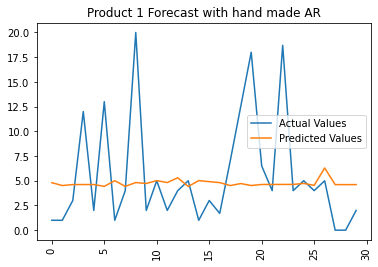

Test RMSE: 5.657


In [77]:
# Product 1
plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.xticks(rotation=90)
plt.title(f'Product {num_product} Forecast with hand made AR')
plt.show()
# evaluate forecast
rmse = sqrt(mean_squared_error(y_test,y_pred))
print('Test RMSE: %.3f' % rmse)

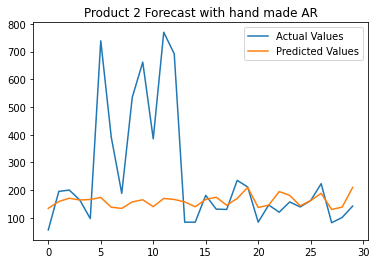

Test RMSE: 225.108


In [91]:
# Product 2
plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title(f'Product {num_product} Forecast with hand made AR')
plt.show()
# evaluate forecast
rmse = sqrt(mean_squared_error(y_test,y_pred))
print('Test RMSE: %.3f' % rmse)

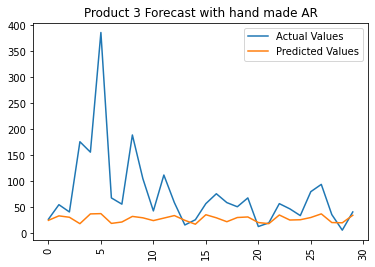

Test RMSE: 84.730


In [105]:
# Product 3
plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.xticks(rotation=90)
plt.title(f'Product {num_product} Forecast with hand made AR')
plt.show()
# evaluate forecast
rmse = sqrt(mean_squared_error(y_test,y_pred))
print('Test RMSE: %.3f' % rmse)

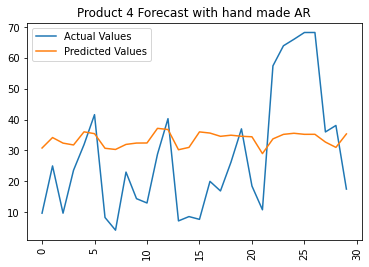

Test RMSE: 19.266


In [119]:
# Product 4
plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.xticks(rotation=90)
plt.title(f'Product {num_product} Forecast with hand made AR')
plt.show()
# evaluate forecast
rmse = sqrt(mean_squared_error(y_test,y_pred))
print('Test RMSE: %.3f' % rmse)

###Forecast each Product with ARIMA package order=(1,0,0) [AR mode]

In [87]:
history = [y for y in y_train]
y_test = [y for y in y_test]
y_pred = []
for t in range(len(y_test)):
	model = ARIMA(history, order=(1,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	y_pred.append(yhat)
	history.append(y_test[t])
	print('predicted=%f, expected=%f' % (yhat, y_test[t]))

predicted=31.954016, expected=9.700000
predicted=30.246046, expected=25.000000
predicted=34.216912, expected=9.700000
predicted=30.190713, expected=23.600000
predicted=33.808337, expected=31.900000
predicted=35.976708, expected=41.600000
predicted=38.518836, expected=8.300000
predicted=29.790847, expected=4.200000
predicted=28.642145, expected=23.000000
predicted=33.572458, expected=14.400000
predicted=31.276947, expected=13.000000
predicted=30.868428, expected=28.800000
predicted=35.048668, expected=40.300000
predicted=38.099197, expected=7.200000
predicted=29.312753, expected=8.600000
predicted=29.625350, expected=7.700000
predicted=29.325686, expected=20.000000
predicted=32.594217, expected=16.900000
predicted=31.737543, expected=26.200000
predicted=34.226250, expected=37.000000
predicted=37.130602, expected=18.500000
predicted=32.143869, expected=10.800000
predicted=30.033195, expected=57.400000
predicted=42.584975, expected=63.900000
predicted=44.370749, expected=66.000000
predict

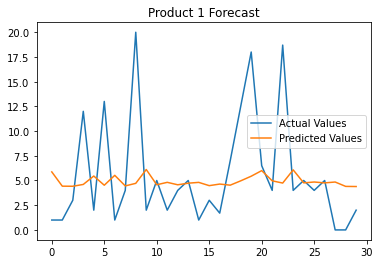

Test RMSE: 5.632


In [34]:
# Product 1
plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title(f'Product {num_product} Forecast with ARIMA model (1,0,0)')
plt.show()
# evaluate forecast
rmse = sqrt(mean_squared_error(y_test,y_pred))
print('Test RMSE: %.3f' % rmse)

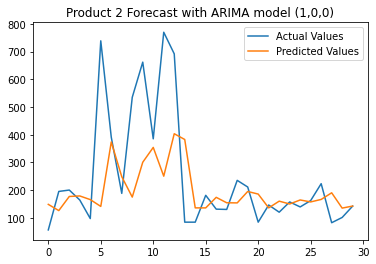

Test RMSE: 193.865


In [52]:
# Product 2
plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title(f'Product {num_product} Forecast with ARIMA model (1,0,0)')
plt.show()
# evaluate forecast
rmse = sqrt(mean_squared_error(y_test,y_pred))
print('Test RMSE: %.3f' % rmse)

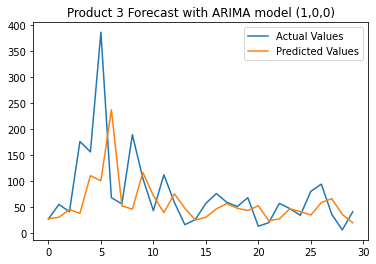

Test RMSE: 75.318


In [70]:
# Product 3
plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title(f'Product {num_product} Forecast with ARIMA model (1,0,0)')
plt.show()
# evaluate forecast
rmse = sqrt(mean_squared_error(y_test,y_pred))
print('Test RMSE: %.3f' % rmse)

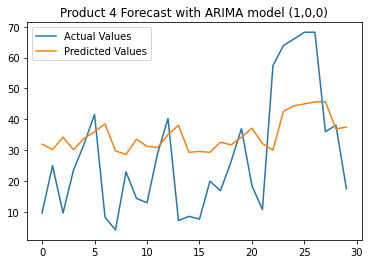

Test RMSE: 18.063


In [88]:
# Product 4
plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title(f'Product {num_product} Forecast with ARIMA model (1,0,0)')
plt.show()
# evaluate forecast
rmse = sqrt(mean_squared_error(y_test,y_pred))
print('Test RMSE: %.3f' % rmse)